# ADA Final Project 


## 1. Data Preprocessing

In [45]:
# Load raw data
import pandas as pd
import numpy as np 
import re
beauty_raw = pd.read_csv("../data/reviews_Beauty_2013_2014.csv")
print(beauty_raw.shape)

productDF = pd.read_csv("../data/product_sub.csv") # 储存产品名字的df
productDF.head(5)

# 把 overall 转换成整数
beauty_raw.overall = beauty_raw.overall.astype(int, inplace = True)


# 检查 missing data & 删掉
percent = (beauty_raw.isnull().sum()/len(beauty_raw)).sort_values(ascending = False)
print(percent)
beauty1 = beauty_raw.loc[beauty_raw.reviewText.notnull(),:]
print(beauty1.shape)

# 删掉只评论过一次的人
filter1 = beauty1.groupby(beauty1.reviewerID).count().overall !=1
beauty = beauty1.loc[beauty1.reviewerID.isin(filter1.index[filter1.values].values),:]
print(beauty.shape)

# 把 helpful 转化成比例
helpful_ratio = beauty.helpful.map(lambda x: int(re.findall(r'\d+',x)[0])/int(re.findall(r'\d+',x)[1]) \
                                   if int(re.findall(r'\d+',x)[1]) !=0 else np.nan )
beauty.loc['helpfulRatio'] = helpful_ratio
# pd.concat([helpful_ratio,beauty.helpful], axis=1)

# ## 保存数据
beauty.to_csv("../data/Beauty.csv")


# 有的productID 不是以B开始的，怎么办？
#beauty_raw.iloc[beauty_raw.ProductID.loc[beauty_raw.ProductID.str[0] != 'B'].index.values]

# 单独生成一个 user,product,rating csv
beauty_rating = beauty[['reviewerID','asin','overall']]
beauty_rating
beauty_rating.to_csv("../data/Beauty_rating.csv")

#pd.concat([helpful_ratio,beauty.helpful], axis=1)


(93607, 9)
reviewText        0.000096
unixReviewTime    0.000000
summary           0.000000
reviewerID        0.000000
reviewTime        0.000000
overall           0.000000
helpful           0.000000
asin              0.000000
Unnamed: 0        0.000000
dtype: float64
(93598, 9)
(91238, 9)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


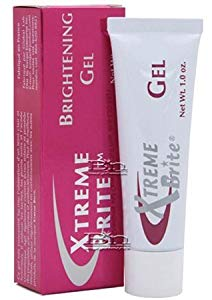

In [73]:
productDF = pd.read_csv("../data/product_sub.csv")
productDF.head(5)
URL = productDF.loc[1,'imUrl']


# from PIL import Image
# import urllib.request

# with urllib.request.urlopen(URL) as url:
#     with open('temp.jpg', 'wb') as f:
#         f.write(url.read())

# img = Image.open('temp.jpg')



## 2. EDA

In [7]:
n_users = beauty.reviewerID.unique().shape[0]
n_items = beauty.asin.unique().shape[0]
print ('Number of users = ' + str(n_users) + ' | Number of items = ' + str(n_items)  )

Number of users = 15007 | Number of items = 11347


Text(0,0.5,'Number of ratings')

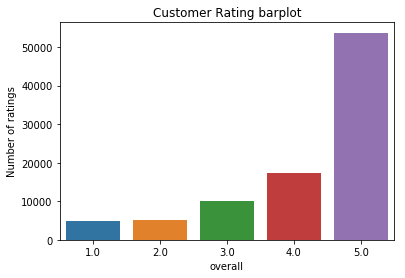

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure()
sns.barplot(beauty.groupby(beauty.overall).count().index,beauty.groupby(beauty.overall).count().asin)
plt.title('Customer Rating barplot')
plt.ylabel('Number of ratings')

In [9]:
# sns.distplot(helpful_ratio,norm_hist = True,kde = True,bins = 118)

## 3. 协同过滤推荐系统

1. Split the beauty_rating into training(70%) and test set(30%)
2. Create a user-item matrix


In [10]:
beauty_rating.dropna(axis = 0, subset=['reviewerID'])
from sklearn.model_selection import train_test_split
training, test = train_test_split(beauty_rating, test_size = 0.3,random_state = 1)

(63867, 3)

In [ ]:
# User-item matrix 
# training_matrix = training.pivot(index = 'reviewerID', columns ='asin', values = 'overall').fillna(np.nan)
# ## Pearson
# import time
# tick = time.time()
# training_pearson = training_matrix.T.corr(method = "pearson")
# tock = time.time()
# print(tock - tick)

### Store the data in a dictionary

In [11]:
listOfDictonaries=[]
indexMap = {}
reverseIndexMap = {}
ptr=0;
testdf=training[['reviewerID','overall']].groupby(training['asin'])
for groupKey in testdf.groups.keys():
    tempDict={}

    groupDF = testdf.get_group(groupKey)
    for i in range(0,len(groupDF)):
        tempDict[groupDF.iloc[i,0]]=groupDF.iloc[i,1]
    indexMap[ptr]=groupKey
    reverseIndexMap[groupKey] = ptr
    ptr=ptr+1
    listOfDictonaries.append(tempDict)

from sklearn.feature_extraction import DictVectorizer
dictVectorizer = DictVectorizer(sparse=True)
vector = dictVectorizer.fit_transform(listOfDictonaries)


from sklearn.metrics.pairwise import cosine_similarity
pairwiseSimilarity = cosine_similarity(vector)



=================INPUT ASIN=========================
ASIN: B004ATTGSY
PRODUCT: Pearl Enterprises M.T. ROLLER 1.5mm Micro Needle Roller Skin Care Therapy Dermatology System (Dermaroller)
=================RECOMMENDATIONS=====================
ASIN: B000FQ73O0
PRODUCT: Minoxidil-5% Extra Strength Hair Regrowth for Men, 3 Count, 2 Ounce Bottles


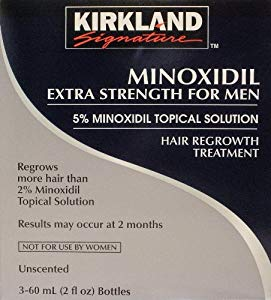

-----------------------------------------------------------------
ASIN: B004LUVN10
PRODUCT: Pearl Enterprises M.T. ROLLER .5mm Micro Needle Roller Skin Care Therapy Dermatology System (Dermaroller)


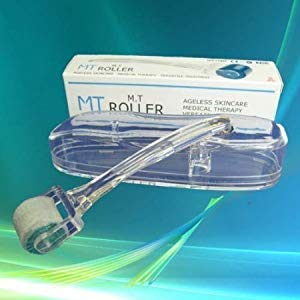

-----------------------------------------------------------------
ASIN: B0002JMZ7A
PRODUCT: Yves Saint Laurent Volume Effet Faux Cils Luxurious Mascara for a False Lash Effect 1 High Density Black


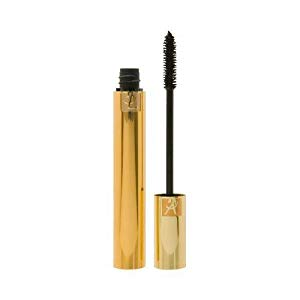

-----------------------------------------------------------------
ASIN: B000KM1PVG
PRODUCT: Earth Therapeutics Natural Wood Pin Massage Brush (Small)


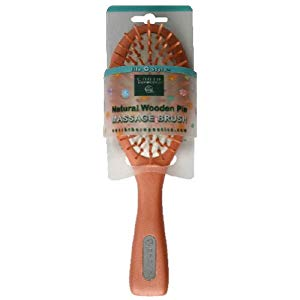

-----------------------------------------------------------------
ASIN: B004IUN7JO
PRODUCT: 100g Pure USAWHR Indigo Powder Indigoferra Tinctoria To dye Hair Black Naturaly NO PPD


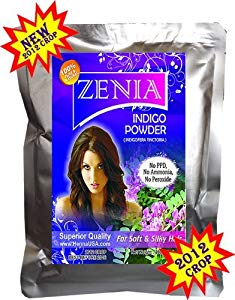

-----------------------------------------------------------------


In [106]:
from IPython.core.display import Image, display
def printBookDetails(asin):
    print("ASIN:",asin)
    #print("CATEGORY:", productDF[productDF['asin']==asin]['categories'].values[0])
    print("PRODUCT:",productDF[productDF['asin']==asin]['title'].values[0])
    URL = productDF[productDF['asin']==asin]['imUrl'].values[0]
    display(Image(URL,  width=150, retina = False,unconfined=True))
    print("-----------------------------------------------------------------")
    


def getTopRecommandations(asin):
    row = reverseIndexMap[asin]
    print("=================INPUT ASIN=========================")
    print("ASIN:",asin)
    print("PRODUCT:",productDF[productDF['asin']==asin]['title'].values[0])
    print("=================RECOMMENDATIONS=====================")
    similarBookIDs = [printBookDetails(indexMap[i]) for i in np.argsort(pairwiseSimilarity[row])[-7:-2][::-1]]

getTopRecommandations('B004ATTGSY')
